In [2]:
import timm
from torchsummary import summary
import torch
from torch import nn
import torch.nn.functional as F
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
from tqdm import tqdm
from tqdm import tqdm_notebook

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
base_model = timm.create_model(
            "tf_efficientnet_b4_ns", pretrained=True, num_classes=1, in_chans=54
        )
summary(base_model, (54,256,256), device='cpu')

-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 48, 128, 128]        23,328
├─BatchNorm2d: 1-2                            [-1, 48, 128, 128]        96
├─SwishMe: 1-3                                [-1, 48, 128, 128]        --
├─Sequential: 1-4                             [-1, 448, 8, 8]           --
|    └─Sequential: 2-1                        [-1, 24, 128, 128]        --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 24, 128, 128]        2,940
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 24, 128, 128]        1,206
|    └─Sequential: 2-2                        [-1, 32, 64, 64]          --
|    |    └─InvertedResidual: 3-3             [-1, 32, 64, 64]          11,878
|    |    └─InvertedResidual: 3-4             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-5             [-1, 32, 6

-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 48, 128, 128]        23,328
├─BatchNorm2d: 1-2                            [-1, 48, 128, 128]        96
├─SwishMe: 1-3                                [-1, 48, 128, 128]        --
├─Sequential: 1-4                             [-1, 448, 8, 8]           --
|    └─Sequential: 2-1                        [-1, 24, 128, 128]        --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 24, 128, 128]        2,940
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 24, 128, 128]        1,206
|    └─Sequential: 2-2                        [-1, 32, 64, 64]          --
|    |    └─InvertedResidual: 3-3             [-1, 32, 64, 64]          11,878
|    |    └─InvertedResidual: 3-4             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-5             [-1, 32, 6

In [13]:
import segmentation.merged_net
reload(segmentation.merged_net)
from segmentation.merged_net import SRM_Classifer
srm = SRM_Classifer()
x, (_merged_input, feat, start, end) = srm(torch.randn(1,3,224,224), (torch.randn(1,3,224,224)))

In [24]:
from segmentation.timm_unetb4 import UnetB4, UnetB4_Inception
un = UnetB4(srm, in_channels=54)
ui = UnetB4_Inception(srm, in_channels=54)

In [26]:
# out = un(torch.randn(1,3,224,224), (torch.randn(1,3,224,224)))
out2 = ui(torch.randn(1,3,224,224), (torch.randn(1,3,224,224)))
out2.shape

torch.Size([1, 1, 224, 224])

In [20]:
import classifier
reload(classifier)
from classifier import ClassifierConv
c = ClassifierConv(21*448)
summary(c, (21*448,8,8), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

Layer (type:depth-idx)                   Output Shape              Param #
├─SeparableConvBnAct: 1-1                [-1, 2352, 8, 8]          --
|    └─Conv2d: 2-1                       [-1, 9408, 8, 8]          84,672
|    └─Conv2d: 2-2                       [-1, 2352, 8, 8]          22,127,616
|    └─BatchNormAct2d: 2-3               [-1, 2352, 8, 8]          --
|    |    └─ReLU: 3-1                    [-1, 2352, 8, 8]          --
├─MaxPool2d: 1-2                         [-1, 2352, 6, 6]          --
├─Dropout2d: 1-3                         [-1, 2352, 6, 6]          --
├─SeparableConvBnAct: 1-4                [-1, 1568, 6, 6]          --
|    └─Conv2d: 2-4                       [-1, 2352, 6, 6]          21,168
|    └─Conv2d: 2-5                       [-1, 1568, 6, 6]          3,687,936
|    └─BatchNormAct2d: 2-6               [-1, 1568, 6, 6]          --
|    |    └─ReLU: 3-2                    [-1, 1568, 6, 6]          --
├─MaxPool2d: 1-5                         [-1, 1568, 4, 4]     

In [27]:
print("Parameters : ", sum(p.numel() for p in ui.parameters() if p.requires_grad))

Parameters :  25220411


In [26]:
import segmentation.timm_efficientnet
reload(segmentation.timm_efficientnet)
from segmentation.timm_efficientnet import EfficientNet
eff = EfficientNet()
summary(eff, (3,256,256))

Layer (type:depth-idx)                             Output Shape              Param #
├─Encoder: 1-1                                     [-1, 1792, 8, 8]          --
|    └─Sequential: 2-1                             [-1, 48, 128, 128]        --
|    |    └─Conv2dSame: 3-1                        [-1, 48, 128, 128]        1,296
|    |    └─BatchNorm2d: 3-2                       [-1, 48, 128, 128]        96
|    |    └─SwishMe: 3-3                           [-1, 48, 128, 128]        --
|    └─Sequential: 2-2                             [-1, 1792, 8, 8]          --
|    |    └─Conv2d: 3-4                            [-1, 1792, 8, 8]          802,816
|    |    └─BatchNorm2d: 3-5                       [-1, 1792, 8, 8]          3,584
|    |    └─SwishMe: 3-6                           [-1, 1792, 8, 8]          --
├─Sequential: 1-2                                  [-1, 112, 8, 8]           --
|    └─Conv2d: 2-3                                 [-1, 112, 8, 8]           50,176
|    └─BatchNorm2d: 

Layer (type:depth-idx)                             Output Shape              Param #
├─Encoder: 1-1                                     [-1, 1792, 8, 8]          --
|    └─Sequential: 2-1                             [-1, 48, 128, 128]        --
|    |    └─Conv2dSame: 3-1                        [-1, 48, 128, 128]        1,296
|    |    └─BatchNorm2d: 3-2                       [-1, 48, 128, 128]        96
|    |    └─SwishMe: 3-3                           [-1, 48, 128, 128]        --
|    └─Sequential: 2-2                             [-1, 1792, 8, 8]          --
|    |    └─Conv2d: 3-4                            [-1, 1792, 8, 8]          802,816
|    |    └─BatchNorm2d: 3-5                       [-1, 1792, 8, 8]          3,584
|    |    └─SwishMe: 3-6                           [-1, 1792, 8, 8]          --
├─Sequential: 1-2                                  [-1, 112, 8, 8]           --
|    └─Conv2d: 2-3                                 [-1, 112, 8, 8]           50,176
|    └─BatchNorm2d: 

In [4]:
from segmentation.timm_efficientnet import EfficientNet
enc = EfficientNet().get_encoder()
inp = torch.randn((1,3,256,256))

x, (start, end), smp = enc(inp)

In [6]:
for i in start.keys():
    print(i, " :", start[i].size())

block_0_layer_0  : torch.Size([1, 24, 128, 128])
block_1_layer_2  : torch.Size([1, 32, 64, 64])
block_2_layer_6  : torch.Size([1, 56, 32, 32])
block_3_layer_10  : torch.Size([1, 112, 16, 16])


In [7]:
for i in end.keys():
    print(i, " :", end[i].size())

block_0_layer_1  : torch.Size([1, 24, 128, 128])
block_1_layer_5  : torch.Size([1, 32, 64, 64])
block_2_layer_9  : torch.Size([1, 56, 32, 32])
block_4_layer_21  : torch.Size([1, 160, 16, 16])


In [2]:
# reload(segmentation.timm_unetb4)
from segmentation.timm_unetb4 import UnetB4, UnetB4_Inception
from segmentation.timm_unetpp import UnetPP
from segmentation.timm_efficientnet import EfficientNet

# unetpp = UnetPP(encoder=EfficientNet().get_encoder())
unetb4 = UnetB4(encoder=EfficientNet().get_encoder())
# unetb4_inc = UnetB4_Inception(encoder=EfficientNet().get_encoder())

In [1]:
# unetb4_inc.encoder.unfreeze()
sum(p.numel() for p in eff.parameters() if p.requires_grad)

NameError: name 'eff' is not defined

In [4]:
(unetb4(torch.randn(1,3,224,224))).shape

torch.Size([1, 1, 224, 224])

In [11]:
reload(classifier)
from classifier import ClassifierBlock
clsf = ClassifierBlock(21*448)

In [12]:
sum(p.numel() for p in clsf.parameters() if p.requires_grad)

5853706

In [41]:
out_128 = torch.randn((21,1792,8,8))

In [49]:
y = torch.nn.functional.adaptive_avg_pool2d(out_128, 1).squeeze()
y.size()

torch.Size([21, 1792])

In [31]:
z = y.T.unsqueeze(0)
z.size()

torch.Size([1, 1792, 16])

In [36]:
p = torch.nn.functional.adaptive_avg_pool1d(z, 1).squeeze(-1)
p.size()

torch.Size([1, 1792])

In [17]:
import classifier_dataset
reload(classifier_dataset)
from classifier_dataset import Classifier_Dataset

DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0/448_tensors"
df = pd.read_csv(f"casia_tensor_448.csv").sample(frac=1).reset_index(drop=True)
dataset = Classifier_Dataset(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    equal_sample=False,
)

real:5992, fakes:4082, mode = train


In [18]:
data = dataset[0]
data['image'].size()

torch.Size([1, 9408, 8, 8])

In [57]:
class Classifier2(nn.Module):
    def __init__(self, in_channels):
        super(Classifier2, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
    def forward(self, x):
        print(x.size())
        y = x.permute((0,2,1))
        print(y.size())
        y = self.gap1D(y).squeeze(-1)
        print(y.size())
        y = self.mlp(y).unsqueeze(1)
        x =  x * y
        print(x.size())
        # x = nn.functional.dropout(x, p=0.3)
        x = x.permute((0,2,1))
        print(x.size())
        x = self.gap1D(x).squeeze(-1)
        print(x.size())
        x = self.fc(x)
        print(x.size())
        return x
cls = Classifier2(32)

In [63]:
cls.eval()
with torch.no_grad():
    out = cls(a.unsqueeze(0))
    print(out.size())
    print(out)

torch.Size([1, 4, 32])
torch.Size([1, 32, 4])
torch.Size([1, 32])
torch.Size([1, 4, 32])
torch.Size([1, 32, 4])
torch.Size([1, 32])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.0875]])


In [55]:
class Classifierold(nn.Module):
    def __init__(self, in_channels):
        super(Classifierold, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
        
    def forward(self, x):
        y = x.T.unsqueeze(0)
        y = self.gap1D(y).squeeze(-1)
        y = self.mlp(y)
        x =  x * y
        
        # x = nn.functional.dropout(x, p=0.3)
        x = x.T.unsqueeze(0)
        x = self.gap1D(x).squeeze(-1)
        
        x = self.fc(x)
        
        return x
clso = Classifierold(32)

In [64]:
clso.eval()
with torch.no_grad():
    out = clso(a)
    print(out.size())
    print(out)

torch.Size([1, 1])
tensor([[0.0641]])


In [71]:
from classifier import ClassifierBlock

classifier = ClassifierBlock(8960)
out = classifier(res)
out.size()

torch.Size([1, 4480, 5, 5])
torch.Size([1, 1792, 3, 3])
torch.Size([1, 1792, 3, 3])
torch.Size([1, 1792, 1, 1])


torch.Size([1, 1])

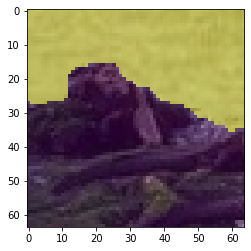

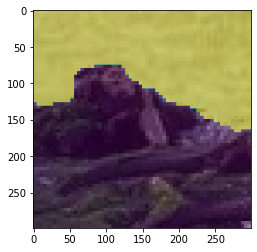

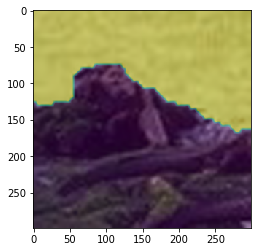

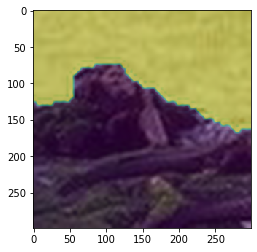

In [65]:
import cv2
import matplotlib.pyplot as plt 

img = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\image_patch_64\\Tp_D_CND_M_N_ani00018_sec00096_00138\\0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
msk = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\image_patch_64\\Tp_D_CND_M_N_ani00018_sec00096_00138\\0_gt.png', cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(img)
plt.imshow(msk, alpha=0.5)
plt.show()

img1 = cv2.resize(img, (299,299), interpolation=cv2.INTER_AREA)
msk1 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_AREA)
plt.figure()
plt.imshow(img1)
plt.imshow(msk1, alpha=0.5)
plt.show()

img2 = cv2.resize(img, (299,299), interpolation=cv2.INTER_CUBIC)
msk2 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(img2)
plt.imshow(msk2, alpha=0.5)
plt.show()

img3 = cv2.resize(img, (299,299), interpolation=cv2.INTER_LANCZOS4)
msk3 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_LANCZOS4)
plt.figure()
plt.imshow(img3)
plt.imshow(msk3, alpha=0.5)
plt.show()

In [7]:
from EffUnet.EfficientUnet import get_blocks_to_be_concat

blocks = get_blocks_to_be_concat(enc, torch.randn((1,3,256,256)))
for b in blocks.items():
    print(b[0], b[1].size())

blocks_0_output_batch_norm --torch.Size([128, 128])
=====>torch.Size([1, 24, 128, 128])
blocks_1_output_batch_norm --torch.Size([128, 128])
blocks_2_output_batch_norm --torch.Size([64, 64])
=====>torch.Size([1, 32, 64, 64])
blocks_3_output_batch_norm --torch.Size([64, 64])
blocks_4_output_batch_norm --torch.Size([64, 64])
blocks_5_output_batch_norm --torch.Size([64, 64])
blocks_6_output_batch_norm --torch.Size([32, 32])
=====>torch.Size([1, 56, 32, 32])
blocks_7_output_batch_norm --torch.Size([32, 32])
blocks_8_output_batch_norm --torch.Size([32, 32])
blocks_9_output_batch_norm --torch.Size([32, 32])
blocks_10_output_batch_norm --torch.Size([16, 16])
=====>torch.Size([1, 112, 16, 16])
blocks_11_output_batch_norm --torch.Size([16, 16])
blocks_12_output_batch_norm --torch.Size([16, 16])
blocks_13_output_batch_norm --torch.Size([16, 16])
blocks_14_output_batch_norm --torch.Size([16, 16])
blocks_15_output_batch_norm --torch.Size([16, 16])
blocks_16_output_batch_norm --torch.Size([16, 16])


In [19]:
from EffUnet.EfficientUnet import get_efficientunet_b4
model = get_efficientunet_b4()

In [10]:
print(model)

EfficientUnet(
  (encoder): Encoder(
    (stem_conv): Conv2dSamePadding(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (stem_batch_norm): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (stem_swish): Swish()
    (blocks): ModuleList(
      (0): MBConvBlock(
        (swish): Swish()
        (_depthwise_conv): Conv2dSamePadding(48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False)
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dSamePadding(48, 12, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand): Conv2dSamePadding(12, 48, kernel_size=(1, 1), stride=(1, 1))
        (_project_conv): Conv2dSamePadding(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (_bn2): BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      )
      (1): MBConvBlock(
        (swish): Swi

In [5]:
summary(model, (3,256,256), device='cpu')

blocks_0_output_batch_norm --torch.Size([128, 128])
=====>torch.Size([2, 24, 128, 128])
blocks_0_output_batch_norm --torch.Size([128, 128])
=====>torch.Size([2, 24, 128, 128])
blocks_1_output_batch_norm --torch.Size([128, 128])
blocks_1_output_batch_norm --torch.Size([128, 128])
blocks_2_output_batch_norm --torch.Size([64, 64])
=====>torch.Size([2, 32, 64, 64])
blocks_2_output_batch_norm --torch.Size([64, 64])
=====>torch.Size([2, 32, 64, 64])
blocks_3_output_batch_norm --torch.Size([64, 64])
blocks_3_output_batch_norm --torch.Size([64, 64])
blocks_4_output_batch_norm --torch.Size([64, 64])
blocks_4_output_batch_norm --torch.Size([64, 64])
blocks_5_output_batch_norm --torch.Size([64, 64])
blocks_5_output_batch_norm --torch.Size([64, 64])
blocks_6_output_batch_norm --torch.Size([32, 32])
=====>torch.Size([2, 56, 32, 32])
blocks_6_output_batch_norm --torch.Size([32, 32])
=====>torch.Size([2, 56, 32, 32])
blocks_7_output_batch_norm --torch.Size([32, 32])
blocks_7_output_batch_norm --torch

-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [-1, 1792, 8, 8]          --
|    └─Conv2dSamePadding: 2-1                 [-1, 48, 128, 128]        1,296
|    └─BatchNorm2d: 2-2                       [-1, 48, 128, 128]        96
|    └─Swish: 2-3                             [-1, 48, 128, 128]        --
|    └─Conv2dSamePadding: 2-4                 [-1, 1792, 8, 8]          802,816
|    |    └─MBConvBlock: 3-1                  [-1, 24, 128, 128]        2,940
|    |    └─MBConvBlock: 3-2                  [-1, 24, 128, 128]        1,206
|    |    └─MBConvBlock: 3-3                  [-1, 32, 64, 64]          11,878
|    |    └─MBConvBlock: 3-4                  [-1, 32, 64, 64]          18,120
|    |    └─MBConvBlock: 3-5                  [-1, 32, 64, 64]          18,120
|    |    └─MBConvBlock: 3-6                  [-

In [20]:
out = model(torch.randn((1,3,256,256)))
print(out.size())

=====>blocks_0_output_batch_norm ,torch.Size([1, 24, 128, 128])
=====>blocks_2_output_batch_norm ,torch.Size([1, 32, 64, 64])
=====>blocks_6_output_batch_norm ,torch.Size([1, 56, 32, 32])
=====>blocks_10_output_batch_norm ,torch.Size([1, 112, 16, 16])
=====>blocks_22_output_batch_norm ,torch.Size([1, 272, 8, 8])
torch.Size([1, 1792, 8, 8])
torch.Size([1, 512, 16, 16])
---blocks_10_output_batch_norm
torch.Size([1, 624, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
---blocks_6_output_batch_norm
torch.Size([1, 312, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])
---blocks_2_output_batch_norm
torch.Size([1, 160, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 128, 128])
---blocks_0_output_batch_norm
torch.Size([1, 88, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 32, 256, 256])
---torch.Size([1, 3, 256, 256])
torch.Size([1, 35, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


here
here


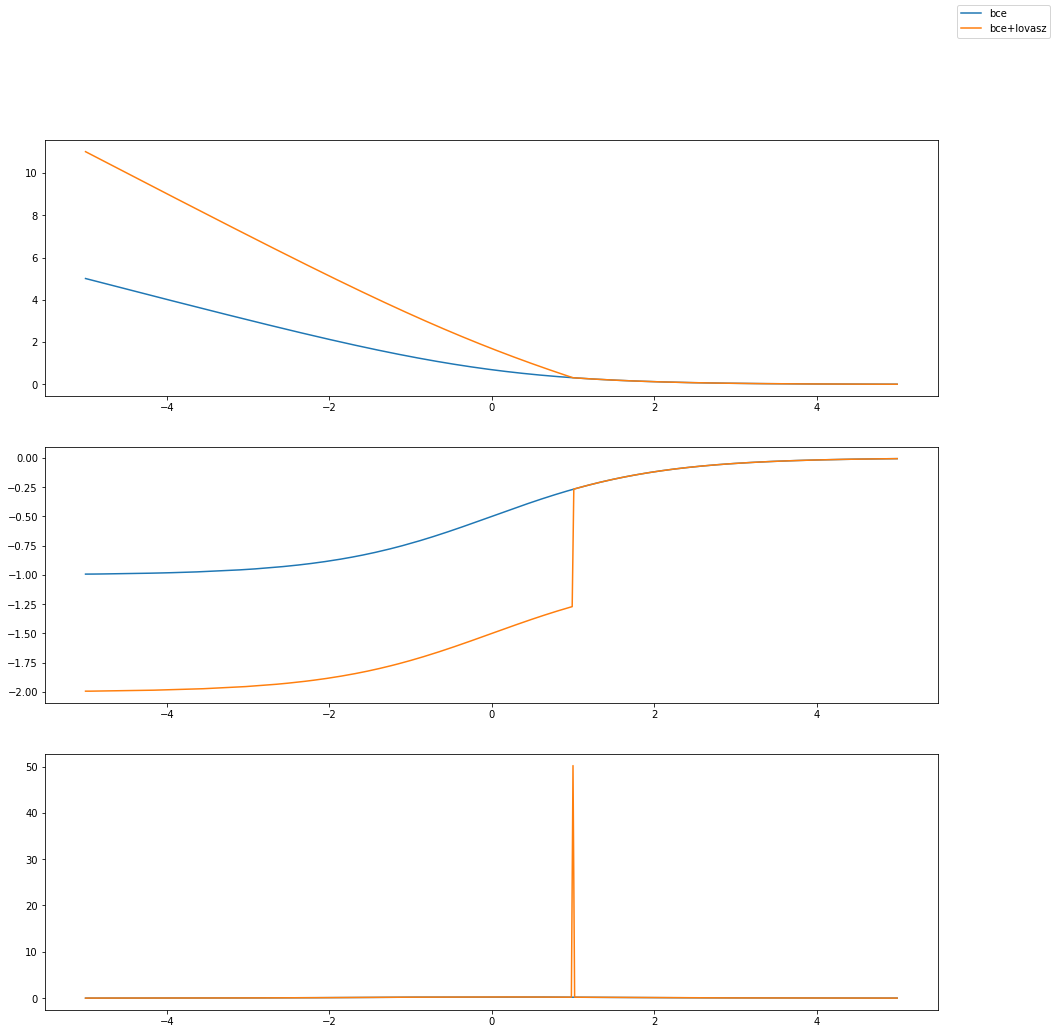

In [2]:
from torch.nn import BCEWithLogitsLoss

from pytorch_toolbelt import losses as L
import numpy as np
import torch
import matplotlib.pyplot as plt


losses = {
    "bce": BCEWithLogitsLoss(),
    # "focal": L.BinaryFocalLoss(),
    # "jaccard": L.BinaryJaccardLoss(),
    # "jaccard_log": L.BinaryJaccardLogLoss(),
    # "dice": L.BinaryDiceLoss(),
    # "dice_log": L.BinaryDiceLogLoss(),
    # "sdice": L.BinarySymmetricDiceLoss(),
    # "sdice_log": L.BinarySymmetricDiceLoss(log_loss=True),
    "bce+lovasz": L.JointLoss(BCEWithLogitsLoss(), L.BinaryLovaszLoss()),
    # "lovasz": L.BinaryLovaszLoss(),
    # "bce+jaccard": L.JointLoss(BCEWithLogitsLoss(),
    #                            L.BinaryJaccardLoss(), 1, 0.5),
    # "bce+log_jaccard": L.JointLoss(BCEWithLogitsLoss(),
    #                            L.BinaryJaccardLogLoss(), 1, 0.5),
    # "bce+log_dice": L.JointLoss(BCEWithLogitsLoss(),
    #                                L.BinaryDiceLogLoss(), 1, 0.5)
    # "reduced_focal": L.BinaryFocalLoss(reduced=True)
}

dx = 0.01
x_vec = torch.arange(-5, 5, dx).view(-1, 1).expand((-1, 100))

f, ax = plt.subplots(3, figsize=(16, 16))

for name, loss in losses.items():
    print('here')
    x_arr = []
    y_arr = []
    target = torch.tensor(1.0).view(1).expand((100))

    for x in x_vec:
        y = loss(x, target).item()

        x_arr.append(float(x[0]))
        y_arr.append(float(y))

    ax[0].plot(x_arr, y_arr, label=name)
    ax[1].plot(x_arr, np.gradient(y_arr, dx))
    ax[2].plot(x_arr, np.gradient(np.gradient(y_arr, dx), dx))

f.legend()
f.show()

In [33]:
from metrics import dice_score

a = torch.randn((4,1,3,3))
b = torch.ones_like(a)
print(a.size(), b.size())
dice = dice_score(a,b)

torch.Size([4, 1, 3, 3])torch.Size([4, 1, 3, 3])
tensor(16.5668)
tensor(52.5668)
tensor(0.6303)
tensor(16.5668)
tensor(52.5668)
tensor(0.6303)


In [51]:
def DiceCoeff(outputs, targets):
    eps = 1e-7
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum(targets * outputs)
    print('inter',intersection)
    union = torch.sum(targets) + torch.sum(outputs)
    print('un',union)
    dice = ((2 * intersection) + eps) / (union + eps)
    print(dice)
    return dice

s = torch.FloatTensor(1).zero_()

for i, c in enumerate(zip(a, b)):
    print(c[0].size())
    s = s + DiceCoeff(c[0], c[1])
print(s)
print(s / (i + 1))

torch.Size([1, 3, 3])
intertensor(3.9308)
untensor(12.9308)
tensor(0.6080)
torch.Size([1, 3, 3])
intertensor(4.7343)
untensor(13.7343)
tensor(0.6894)
torch.Size([1, 3, 3])
intertensor(4.3832)
untensor(13.3832)
tensor(0.6550)
torch.Size([1, 3, 3])
intertensor(3.5186)
untensor(12.5186)
tensor(0.5621)
tensor([2.5145])
tensor([0.6286])


In [49]:
DiceCoeff(a,b)

tensor(16.5668)
tensor(52.5668)
tensor(0.6303)


tensor(0.6303)

In [46]:
def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """
    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:
    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.
    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        print(intersection)
        cardinality = torch.sum(output + target)
        print(cardinality)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [53]:
soft_dice_score(torch.sigmoid(a),b)

tensor(16.5668)
tensor(52.5668)


tensor(0.6303)

In [24]:
image = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\Tp\\Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import albumentations
from albumentations import augmentations

image = albumentations.Compose(
        [
            augmentations.transforms.Resize(
                256, 256, interpolation=cv2.INTER_AREA, always_apply=True, p=1
            )
        ]
    )(image=image)['image']

reload(segmentation.timm_efficientnet)
from segmentation.timm_efficientnet import EfficientNet
model = EfficientNet(freeze_encoder=True).get_encoder()

In [2]:
from segmentation.timm_efficientnet import EfficientNet
import image_ensemble
reload(image_ensemble)
from image_ensemble import ensemble

patch_size = 'FULL'
DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0"
df = pd.read_csv(f"casia_{patch_size}.csv").sample(frac=1).reset_index(drop=True)
model = EfficientNet().get_encoder().cuda()

In [5]:
image = cv2.imread('Image_Manipulation_Dataset/CASIA_2.0/Tp/Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)

out = ensemble(model, image)
out.shape

--------- Loaded Checkpoint: 256_encoder.h5 ----------
torch.Size([1, 448, 8, 8])
--------- Loaded Checkpoint: 128_encoder.h5 ----------
torch.Size([4, 448, 8, 8])
--------- Loaded Checkpoint: 64_encoder.h5 ----------
torch.Size([16, 448, 8, 8])


torch.Size([21, 448, 8, 8])

In [3]:
df['tensor'] = -1
df.head()

image_patch  \
0  Tp/Tp_D_CRN_M_N_art10112_cha00086_11672.jpg   
1                          Au/Au_ind_20061.jpg   
2  Tp/Tp_S_CRN_S_N_ind00081_ind00081_00479.tif   
3                          Au/Au_sec_10111.jpg   
4  Tp/Tp_D_NRN_S_O_ani10102_ani10104_10023.tif   

                                       mask_patch  label  fold  tensor  
0  Gt/Tp_D_CRN_M_N_art10112_cha00086_11672_gt.png      1     4      -1  
1                                             NaN      0     0      -1  
2  Gt/Tp_S_CRN_S_N_ind00081_ind00081_00479_gt.png      1     0      -1  
3                                             NaN      0     4      -1  
4  Gt/Tp_D_NRN_S_O_ani10102_ani10104_10023_gt.png      1     3      -1

In [4]:
DIR = 'Image_Manipulation_Dataset/CASIA_2.0/448_tensors'
with tqdm_notebook(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        fname = row['image_patch'].split('/')[-1][:-4]
        if os.path.exists(os.path.join(DIR, fname+".pt")):
            df.loc[i, 'tensor'] = fname+".pt"
        else:
            image = cv2.imread(os.path.join(DATA_ROOT, row['image_patch']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)
            # plt.imshow(image)
            # plt.show()
            tensor = ensemble(model, image)
            tensor = tensor.cpu()
            torch.save(tensor, os.path.join(DIR, fname+".pt"))
            df.loc[i, 'tensor'] = fname+".pt"
        pbar.update(1)

In [7]:
df.to_csv('casia_tensor_448.csv', index=False)

In [7]:
from casia_dataset import CASIA

patch_size = 'FULL'
DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0"
df = pd.read_csv(f"casia_{patch_size}.csv").sample(frac=1).reset_index(drop=True)

normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)
valid_dataset = CASIA(
    dataframe=df,
    mode="val",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    patch_size=patch_size,
    equal_sample=False,
    transforms=valid_aug,
)

real:750, fakes:510, mode = val


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([3, 224, 224])


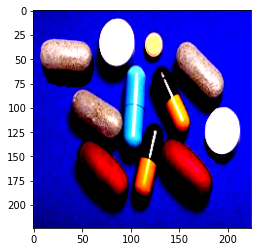

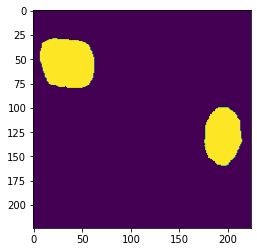

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


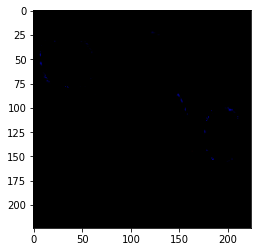

In [37]:
data = valid_dataset[5]
print(data['image'].size())
plt.figure()
plt.imshow(data['image'].permute((1,2,0)))
plt.show()
plt.figure()
plt.imshow(data['mask'].permute((1,2,0)).squeeze())
plt.show()
plt.figure()
plt.imshow(data['ela'].permute((1,2,0)).squeeze())
plt.show()

In [2]:
x = []
y = []
a = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,1,1,1,1,1,1,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0]
])
b = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0.5,0.75,0,0,0,0],
    [0,0,0,0.9,0.85,0.77,0.65,0,0,0],
    [0,0,0.88,1,0.65,1,0.71,0.98,0,0],
    [0,0,0,1,0.33,1,0.84,0,0,0],
    [0,0,0,0,0.25,0.77,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0]
])

In [35]:
def dice_score(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets + outputs)
    dice = ((2 * intersection) + eps) / (union + eps)
    
    return dice #single float

In [3]:
from pytorch_toolbelt.losses.functional import soft_dice_score

def dice_coeff(outputs : list, targets : list): 
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(outputs, targets)):
        s = s + soft_dice_score(c[0], c[1])
    return s / (i + 1)

In [5]:
dice_coeff(y,x)

0.868991494178772

In [47]:
import segmentation_models_pytorch as smp 

model = smp.Unet('timm-efficientnet-b4', classes=1, encoder_weights='imagenet')

encoder = model.encoder

In [9]:
inp = torch.randn((1,3,256,256))

In [26]:
out = encoder(inp)

In [20]:
soft_dice_score(b,a).item()

torch.Size([1, 3, 256, 256])
torch.Size([1, 48, 128, 128])
torch.Size([1, 32, 64, 64])
torch.Size([1, 56, 32, 32])
torch.Size([1, 160, 16, 16])
torch.Size([1, 448, 8, 8])


(5, 6, 224, 224)


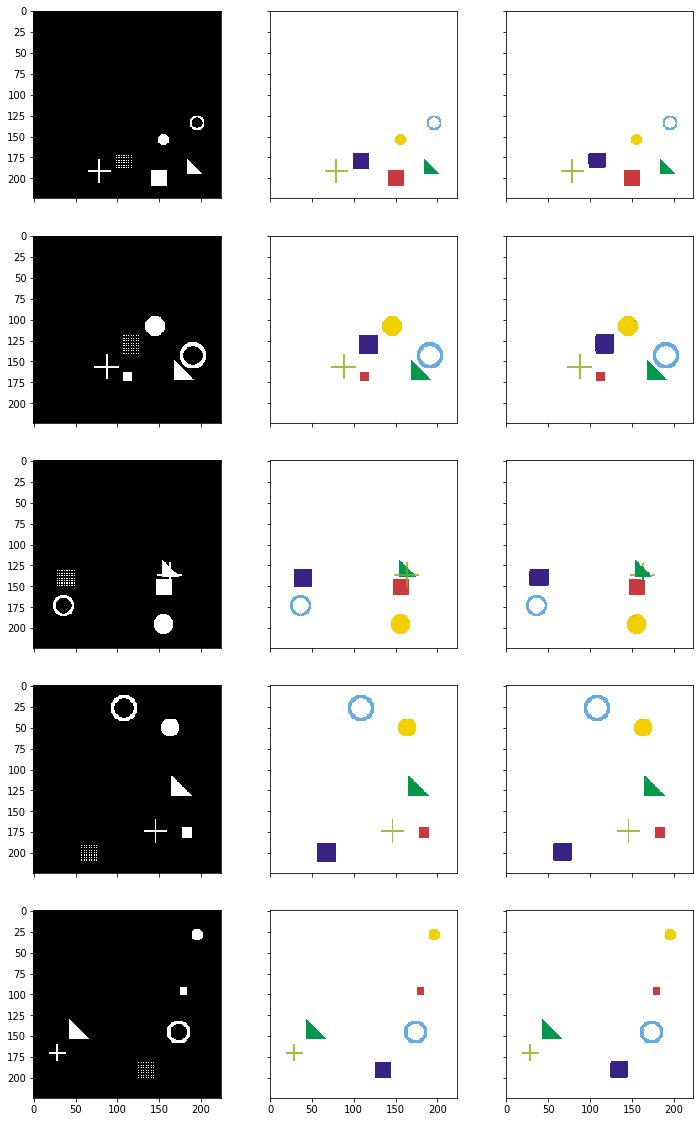

In [8]:
# import segmentation_models_pytorch as smp
# from segmentation.smp_effb4 import SMP_DIY
from segmentation.timm_unetb4 import UnetB4
from segmentation.timm_unetpp import UnetPP
from segmentation.timm_efficientnet import EfficientNet
from sim_dataset import SimDataset
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import helper
from torchvision import transforms

device = 'cuda'
encoder = EfficientNet().get_encoder()
model = UnetPP(encoder, num_classes=6)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('weights/Simulation_64Unet++ unfreeze-encoder_[06|10_19|51|36].h5'))
model.to(device)
model.eval()   # Set model to the evaluation mode

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
# Create another simulation dataset for test
test_dataset = SimDataset(5, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
data = next(iter(test_loader))
inputs = data['image']
labels = data['mask']
inputs = inputs.to(device)
labels = labels.to(device)


# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().detach().numpy()
print(pred.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [7]:
import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain

In [5]:
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff

In [2]:
DIR = 'Image_Manipulation_Dataset/CASIA_2.0'
df = pd.read_csv('casia_FULL.csv')

In [8]:
with tqdm_notebook(total=df.shape[0]) as pbar:
    cnt = 0
    for i, row in df.iterrows():
        # if row['label'] == 0:
        cnt += 1
        # image_name = row['image']
        # image_patch = 

        image_path = os.path.join(DIR, row['image_patch'])
        ela_path = os.path.join(DIR, row['ela'])
        # plt.imshow(image)
        # plt.show()
        ela = ELA(image_path)
        ela.save(ela_path)
        # df.loc[i, 'ela'] = 'ela_'+image_patch
        # print(ela_path)
        # if cnt >= 5:
        #     break
        pbar.update(1)

In [14]:
df.to_csv('casia_128.csv', index=False)

In [3]:
import segmentation.merged_net
reload(segmentation.merged_net)

from segmentation.timm_unetb4 import UnetB4
from segmentation.merged_net import SRM_Classifer

model = UnetB4(SRM_Classifer(), in_channels=54).cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('weights/224CASIA_64UnetB4(ELA)_[12|10_13|24|39].h5'))
print(model.eval())

DataParallel(
  (module): UnetB4(
    (encoder): SRM_Classifer(
      (srm_conv): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bayer_conv): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (rgb_conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (ela_net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (encoder): Encoder(
        (stem): Sequential(
          (0): Conv2dSame(54, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=0.001, moment

In [14]:
df = pd.read_csv(f"casia_64.csv").reset_index(drop=True)
rows = df[df["fold"] == 0]

# real = rows[rows["label"] == 0].sample(n=50)
fakes = rows[rows["label"] == 1].sample(n=100)

data = pd.concat([fakes])
data = data.values

normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], always_apply=True, p=1),
        albumentations.pytorch.ToTensor()
    ],
    additional_targets={'ela':'image'}
)

Dice:0.6045406460762024, IOU:0.4332197904586792


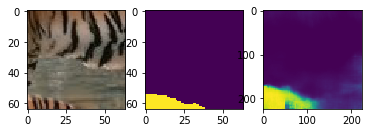

Dice:0.38324543833732605, IOU:0.23704615235328674


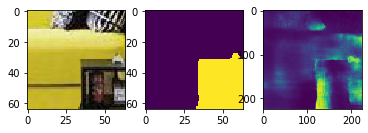

Dice:0.4293041229248047, IOU:0.2733209729194641


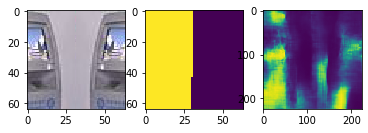

Dice:0.2618527114391327, IOU:0.15065047144889832


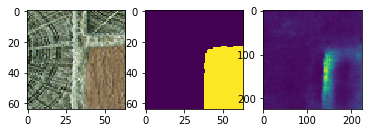

Dice:0.20918087661266327, IOU:0.11680737137794495


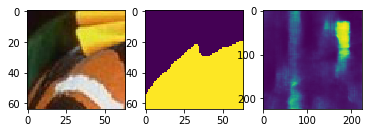

Dice:0.12552405893802643, IOU:0.06696488708257675


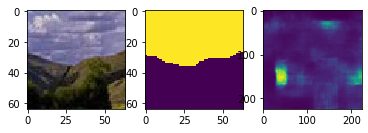

Dice:0.15613898634910583, IOU:0.08468044549226761


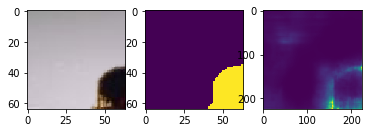

Dice:0.30397656559944153, IOU:0.1792289912700653


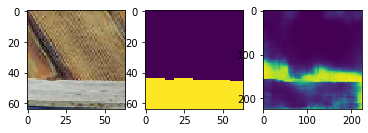

Dice:0.37622857093811035, IOU:0.23170043528079987


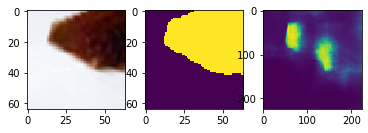

Dice:0.1060897558927536, IOU:0.05601625517010689


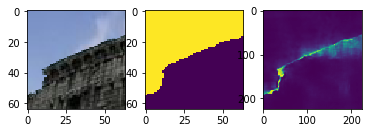

Dice:0.08444759249687195, IOU:0.044085245579481125


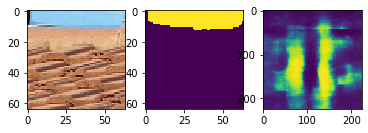

Dice:0.21625719964504242, IOU:0.12123788893222809


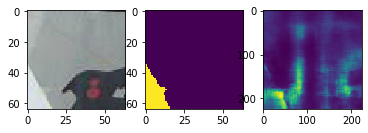

Dice:0.1484750658273697, IOU:0.08019068837165833


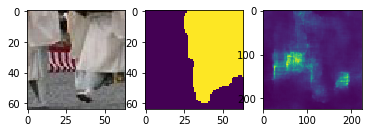

Dice:0.4668545424938202, IOU:0.30450764298439026


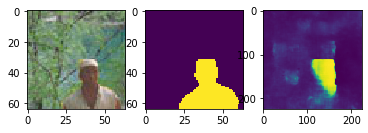

Dice:0.15329378843307495, IOU:0.08300930261611938


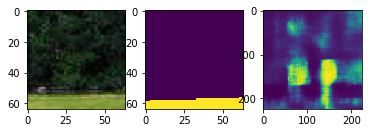

Dice:0.10061095654964447, IOU:0.05297016352415085


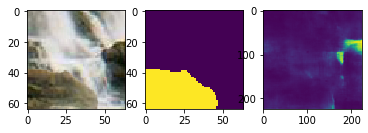

Dice:0.10611555725336075, IOU:0.05603064224123955


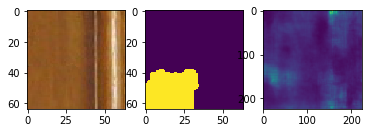

Dice:0.2600274682044983, IOU:0.14944343268871307


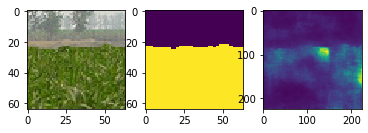

Dice:0.27679944038391113, IOU:0.16063101589679718


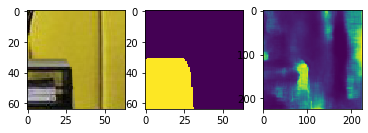

Dice:0.0721135064959526, IOU:0.03740547224879265


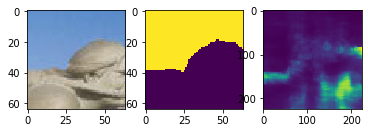

Dice:0.8346630930900574, IOU:0.7162418961524963


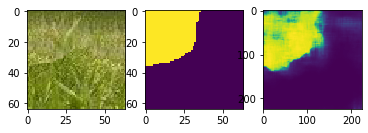

Dice:0.15115797519683838, IOU:0.08175818622112274


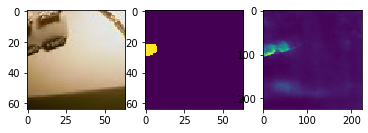

Dice:0.04696781560778618, IOU:0.024048663675785065


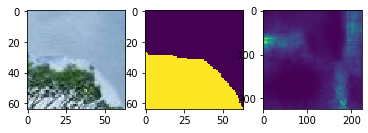

Dice:0.04446041211485863, IOU:0.02273562364280224


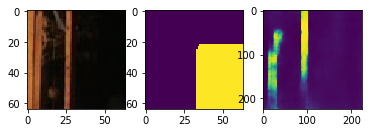

Dice:0.19160309433937073, IOU:0.10595190525054932


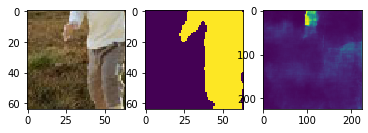

Dice:0.2593373656272888, IOU:0.14898774027824402


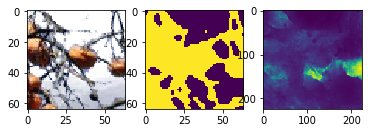

Dice:0.1946028769016266, IOU:0.10778950899839401


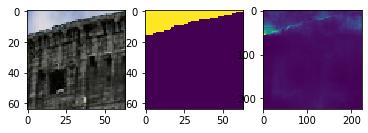

Dice:0.103652223944664, IOU:0.05465886741876602


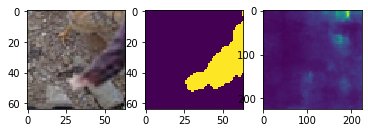

Dice:0.07526201754808426, IOU:0.039102476090192795


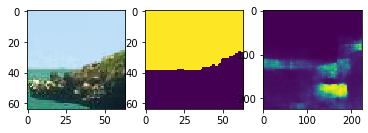

Dice:0.7137743234634399, IOU:0.5549371242523193


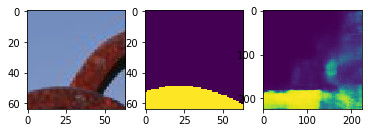

Dice:0.15359239280223846, IOU:0.08318444341421127


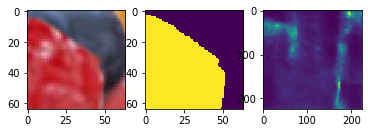

Dice:0.25368109345436096, IOU:0.14526619017124176


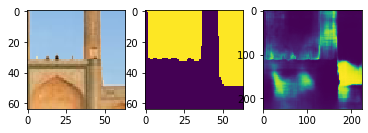

Dice:0.15429724752902985, IOU:0.08359809964895248


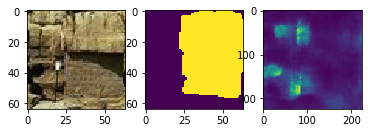

Dice:0.23189300298690796, IOU:0.13115327060222626


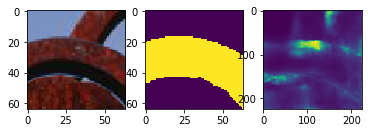

Dice:0.14002656936645508, IOU:0.07528417557477951


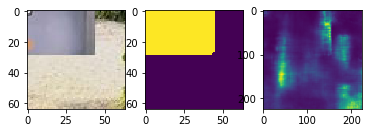

Dice:0.10094784945249557, IOU:0.05315696820616722


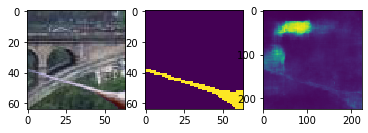

Dice:0.06508954614400864, IOU:0.033639565110206604


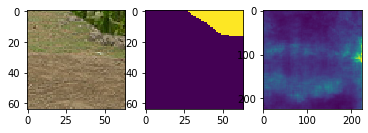

Dice:0.21490074694156647, IOU:0.12038587778806686


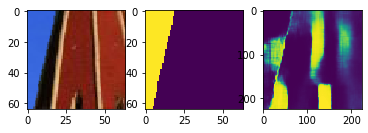

Dice:0.10978266596794128, IOU:0.05807938799262047


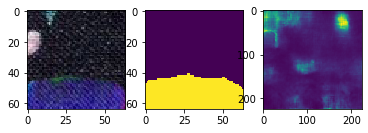

Dice:0.2248336374759674, IOU:0.1266549676656723


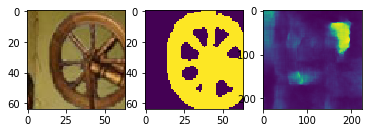

Dice:0.33463507890701294, IOU:0.20093797147274017


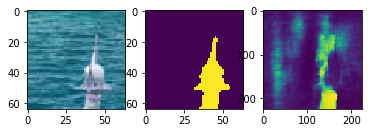

Dice:0.10323454439640045, IOU:0.05442662909626961


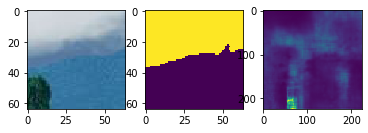

Dice:0.44642582535743713, IOU:0.287354052066803


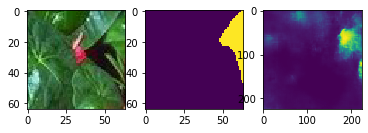

Dice:0.3356073796749115, IOU:0.2016395479440689


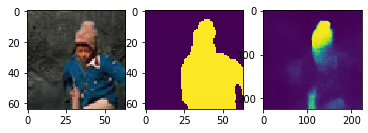

Dice:0.16217555105686188, IOU:0.08824321627616882


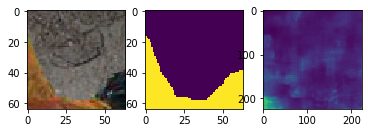

Dice:0.145199254155159, IOU:0.07828293740749359


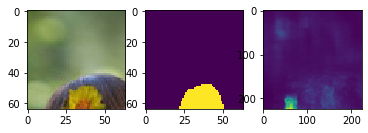

Dice:0.061818379908800125, IOU:0.03189503774046898


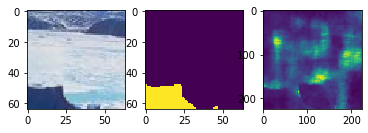

Dice:0.18680769205093384, IOU:0.10302696377038956


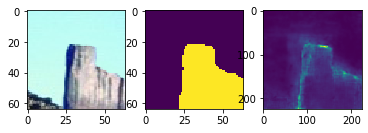

Dice:0.13921333849430084, IOU:0.07481423765420914


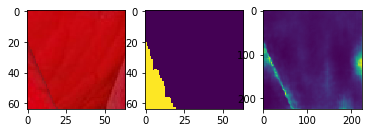

Dice:0.6827563047409058, IOU:0.5183219909667969


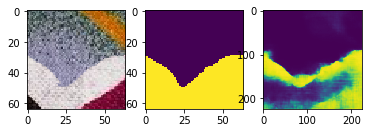

Dice:0.1820075511932373, IOU:0.10011459141969681


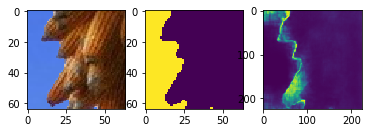

Dice:0.12783952057361603, IOU:0.06828448921442032


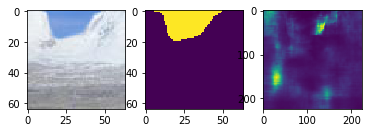

Dice:0.3008689284324646, IOU:0.17707222700119019


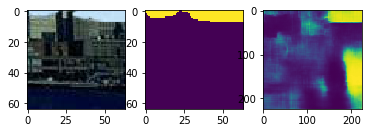

Dice:0.21615298092365265, IOU:0.12117238342761993


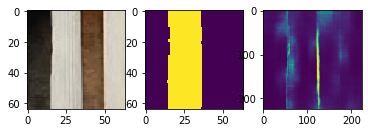

Dice:0.3505820035934448, IOU:0.21254891157150269


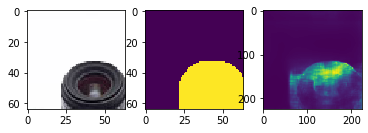

Dice:0.053374022245407104, IOU:0.02741873450577259


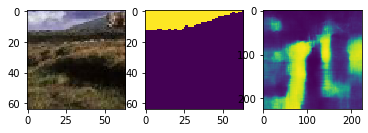

Dice:0.07239263504743576, IOU:0.037555694580078125


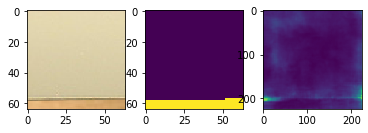

Dice:0.6825312376022339, IOU:0.5180625319480896


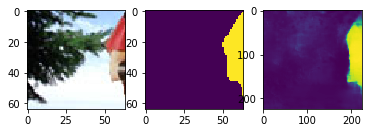

Dice:0.2300603836774826, IOU:0.12998205423355103


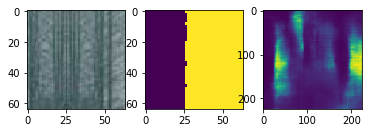

Dice:0.10963757336139679, IOU:0.0579981729388237


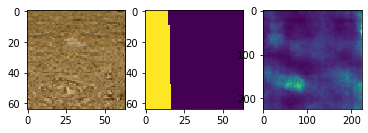

Dice:0.06475047767162323, IOU:0.033458463847637177


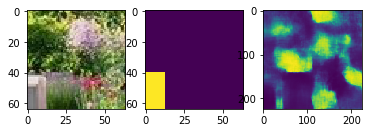

Dice:0.45379239320755005, IOU:0.2934873700141907


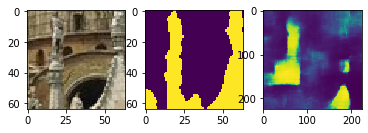

Dice:0.4856191873550415, IOU:0.32067179679870605


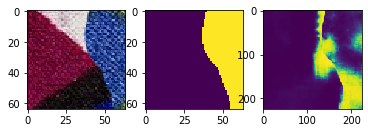

Dice:0.20742878317832947, IOU:0.11571578681468964


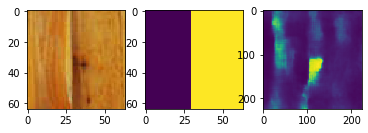

Dice:0.2170172482728958, IOU:0.12171583622694016


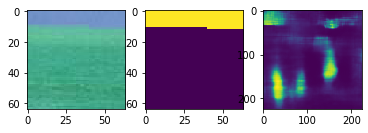

Dice:0.4154708981513977, IOU:0.262204647064209


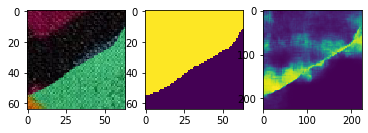

Dice:0.18641972541809082, IOU:0.10279099643230438


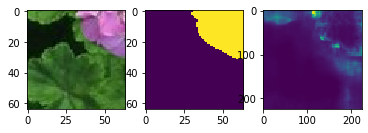

Dice:0.06850384920835495, IOU:0.03546672686934471


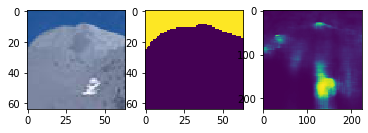

Dice:0.08209605515003204, IOU:0.04280509054660797


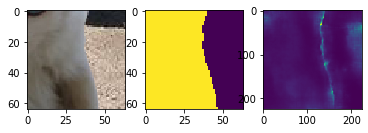

Dice:0.2749474048614502, IOU:0.15938492119312286


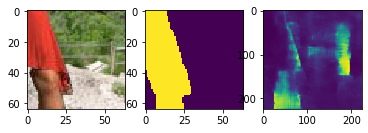

Dice:0.13640128076076508, IOU:0.07319241017103195


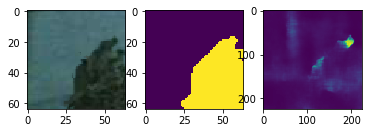

Dice:0.1643461436033249, IOU:0.08953002840280533


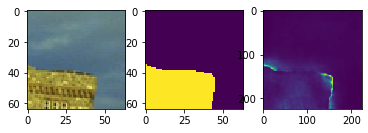

Dice:0.39433059096336365, IOU:0.24558641016483307


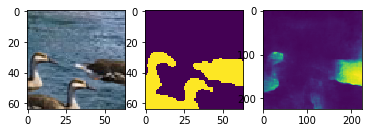

Dice:0.10174939036369324, IOU:0.05360166355967522


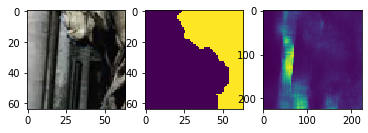

Dice:0.12705078721046448, IOU:0.06783461570739746


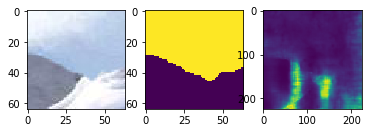

Dice:0.2065403312444687, IOU:0.11516307294368744


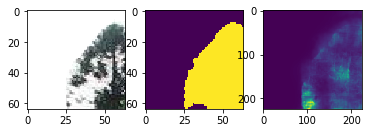

Dice:0.06764724105596542, IOU:0.03500770777463913


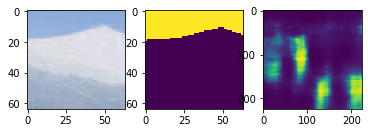

Dice:0.3351879119873047, IOU:0.20133677124977112


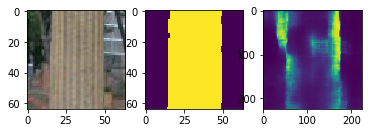

Dice:0.26432129740715027, IOU:0.15228700637817383


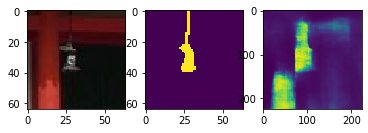

Dice:0.07480411231517792, IOU:0.03885532170534134


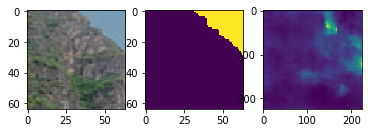

Dice:0.03808138892054558, IOU:0.019410278648138046


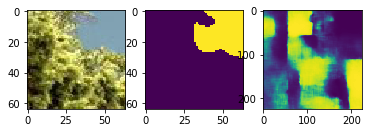

Dice:0.2220069020986557, IOU:0.12486375868320465


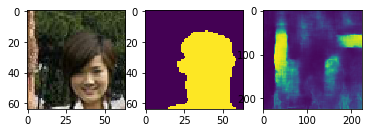

Dice:0.11538948863744736, IOU:0.061227232217788696


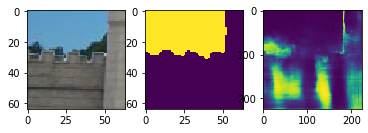

Dice:0.13265474140644073, IOU:0.07103921473026276


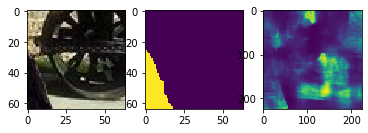

Dice:0.18196500837802887, IOU:0.10008883476257324


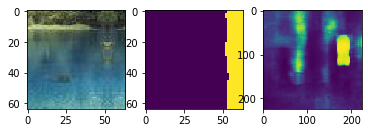

Dice:0.06419572234153748, IOU:0.033162299543619156


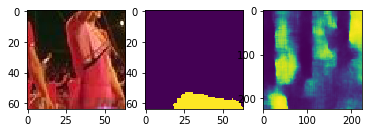

Dice:0.11767715960741043, IOU:0.06251698732376099


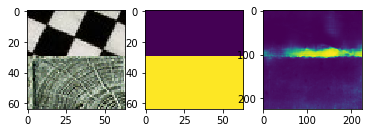

Dice:0.08608239889144897, IOU:0.04497706890106201


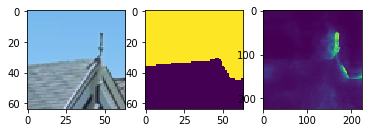

Dice:0.23159663379192352, IOU:0.13096369802951813


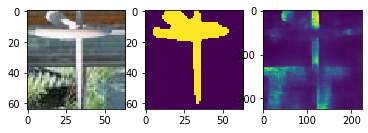

Dice:0.0011977390386164188, IOU:0.0005992284277454019


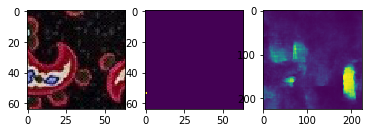

Dice:0.09279857575893402, IOU:0.04865693673491478


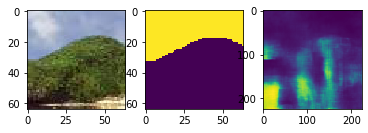

Dice:0.6446638107299805, IOU:0.4756486117839813


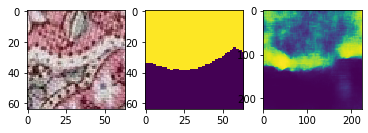

Dice:0.07053574174642563, IOU:0.0365571603178978


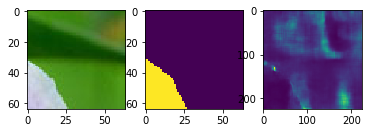

Dice:0.09359291195869446, IOU:0.04909387230873108


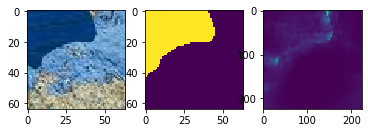

Dice:0.08056379854679108, IOU:0.04197263345122337


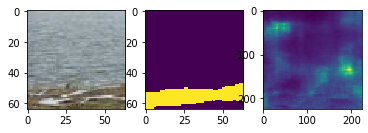

Dice:0.10933471471071243, IOU:0.057828694581985474


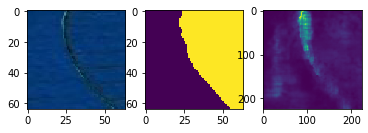

Dice:0.08117993175983429, IOU:0.04230721667408943


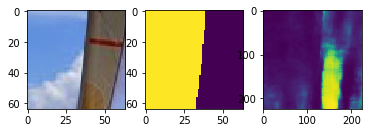

Dice:0.17891569435596466, IOU:0.09824679791927338


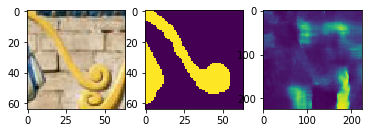

Dice:0.09073388576507568, IOU:0.04752290993928909


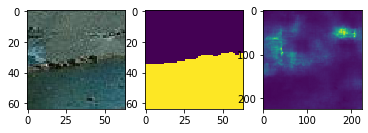

Dice:0.27855467796325684, IOU:0.16181440651416779


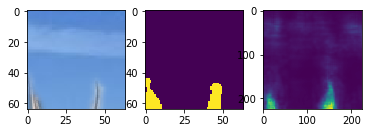

Total Dice:0.27855467796325684, Total IOU:0.16181440651416779
Best Dice: 0.27855467796325684, Count = 3099.0, IDX : 0
Best IOU: 0.16181440651416779, Count = 3099.0, IDX : 0
Total Dice2:0.27855467796325684, Total IOU2:0.16181440651416779


In [13]:
from pytorch_toolbelt import losses
from utils import *
import seg_metrics

root_dir = 'Image_Manipulation_Dataset/CASIA_2.0/image_patch_64'
for row in data:
    image_name, image_patch, mask_patch, label, fold, ela = row

    image_path = os.path.join(root_dir, image_name, image_patch)
    ela_path = os.path.join(root_dir, image_name, ela)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ela_image = cv2.imread(ela_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

    if not isinstance(mask_patch, str) and np.isnan(mask_patch):
        mask_image = np.zeros((image.shape[0], image.shape[1]))
    else:
        mask_path = os.path.join(root_dir, image_name, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    trans = valid_aug(image=image, mask=mask_image, ela=ela_image)
    tensor = trans["image"].unsqueeze(0).cuda()
    mask_tensor = trans["mask"].unsqueeze(0).cuda()
    ela_tensor = trans["ela"].unsqueeze(0).cuda()

    dice_tot = AverageMeter()
    jaccard_tot = AverageMeter()
    preds = []
    targets = []
    with torch.no_grad():
        out_mask = model(tensor, ela_tensor)
        out_mask = torch.sigmoid(out_mask.cpu())
        mask_tensor = mask_tensor.cpu()

        dice = losses.functional.soft_dice_score(out_mask, mask_tensor)
        dice_tot.update(dice)
        jaccard = losses.functional.soft_jaccard_score(out_mask, mask_tensor)
        jaccard_tot.update(jaccard)

        preds.append(out_mask)
        targets.append(mask_tensor)
    print(f"Dice:{dice}, IOU:{jaccard}")
    plt.figure(1)
    plt.subplot(131)
    plt.imshow(image)

    plt.subplot(132)
    plt.imshow(mask_image)

    plt.subplot(133)
    plt.imshow(image2np(out_mask.squeeze(0)))
    plt.show()

print(f"Total Dice:{dice_tot.avg}, Total IOU:{jaccard_tot.avg}")
dice_tot2, best_dice = seg_metrics.dice_coeff(preds, targets)  
jaccard_tot2, best_iou = seg_metrics.jaccard_coeff(preds, targets) 
print(f"Total Dice2:{dice_tot2.item()}, Total IOU2:{jaccard_tot2.item()}")

In [17]:
import casia_dataset
reload(casia_dataset)
from casia_dataset import CASIA
train_dataset = CASIA(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=9,
    root_dir=root_dir,
    patch_size=64,
    transforms=valid_aug,
    segment=True
)

real:0, fakes:24324, mode = train
